# LLM Iteration 28

**Aim**

To create a plot of the mean waiting times and number of patients waiting across the multiple replications warm-up analysis to choose the warm-up period.

**Prompt**

Use the output results dictionary to create a time_series_inspection function. This should create a plot with 2 subplots. The mean of the columns in the dataframe containing the number of patients waiting and bed waiting time should be calculated and this should be plotted against the time in days of the model run. An option should be included to be able to add a line on the plot to indicate the point at which a steady state has been reached, which will be used as the warm-up period. 

**Note**

Modifications have been made to the output from the LLM, indicated by:
```python
########## MODIFICATION ##########
change
##################################
```
This is either used to add in code from previous iterations if only certain sections were updated, used to correct the LLM's code if required, or used to check the model is working as expected.

**Additional code to run model**

In [1]:
def trace(msg):
    '''
    Utility function for printing simulation.
    Set the TRACE constant to FALSE to turn tracing off.
    
    Params:
    -------
    msg: str
        string to print to screen.
    '''
    if TRACE:
        print(msg)

In [2]:
TRACE = False

In [3]:
import simpy
import numpy as np
import math
import pandas as pd

In [5]:
class Scenario:
    def __init__(self, num_beds, run_length=60*2, seed=None):
        self.num_beds = num_beds
        self.run_length = run_length
        self.seed = seed
        self.default_interarrival_times = {
            "Stroke": 1.2,
            "TIA": 9.3,
            "Complex Neurological": 3.6,
            "Other": 3.2
        }
        self.random_seeds = {
            "Stroke": 12345,
            "TIA": 54321,
            "Complex Neurological": 98765,
            "Other": 67890
        }

    def create_distributions(self, num_runs):
        interarrival_distributions = {}
        seeds = self.generate_seeds(num_runs)
        for patient_type, seed in seeds.items():
            if seed[0] is not None:
                np.random.seed(seed)
                interarrival_distributions[patient_type] = np.random.\
                    default_rng(seed)
            else:
                interarrival_distributions[patient_type] = np.random.\
                    default_rng()
        return interarrival_distributions

    def generate_seeds(self, num_runs):
        seeds = {}
        for patient_type, seed in self.random_seeds.items():
            if self.seed is not None:
                seeds[patient_type] = [seed + i + self.seed for i in \
                                       range(num_runs)]
            else:
                seeds[patient_type] = [None for i in range(num_runs)]
        return seeds

In [5]:
class StrokeWard:
    def __init__(self, scenario):
        self.env = simpy.Environment()
        self.beds = simpy.Resource(self.env, capacity=scenario.num_beds)
        self.patient_count = 0
        self.wait_times = []
        self.waiting_patients = []
        self.length_of_stay = {
            "Stroke": {"mean": 7.4, "std_dev": 8.6},
            "TIA": {"mean": 1.8, "std_dev": 2.3},
            "Complex Neurological": {"mean": 4.0, "std_dev": 5.0},
            "Other": {"mean": 3.8, "std_dev": 5.2}
        }
        self.interarrival_distributions = scenario.\
            create_distributions(num_runs=1)
        self.route_probabilities = {
            "Stroke": {"ESD": 0.13, "Rehab Unit": 0.24, "Other": 0.63},
            "TIA": {"ESD": 0.01, "Rehab Unit": 0.01, "Other": 0.98},
            "Complex Neurological": {"ESD": 0.05, "Rehab Unit": 0.11,
                                     "Other": 0.84},
            "Other": {"ESD": 0.10, "Rehab Unit": 0.05, "Other": 0.85}
        }
        self.patients_in_beds = 0
        self.bed_in_use_store = []
        self.patient_type_store = []
        self.los_store = []

    def update_length_of_stay(self, patient_type, destination):
        if patient_type == 'Stroke':
            if destination == 'ESD':
                return {"mean": 4.6, "std_dev": 4.8}
            elif destination == 'Other':
                # Mortality rate for Stroke patients going to Other
                if np.random.rand() < 0.02:
                     # Adjusted parameters for mortality case
                    return {"mean": 7.0, "std_dev": 8.7}
        return self.length_of_stay[patient_type]

    def admit_patient(self, patient):
        arrival_time = round(self.env.now, 2)
        with self.beds.request() as bed:
            yield bed
            bed_arrival_time = self.env.now
            self.patients_in_beds += 1
            self.bed_in_use_store.append(self.patients_in_beds)
            self.patient_type_store.append(patient.patient_type)

            wait_time = max(0, round(self.env.now - arrival_time, 2))
            self.wait_times.append(wait_time)
            self.waiting_patients.append(len(self.beds.queue))

            trace(f'Patient {patient.id} ({patient.patient_type}) admitted '
                  f'to the stroke ward at day {round(self.env.now, 2)}. '
                  f'Wait time: {wait_time} days')

            route_probabilities = list(self.route_probabilities[patient.\
                                       patient_type].values())
            route_names = list(self.route_probabilities[patient.\
                               patient_type].keys())

            rng = np.random.default_rng(patient.seed)
            route_choice = rng.choice(route_names, p=route_probabilities)

            length_of_stay_params = self.update_length_of_stay(patient.\
                                                               patient_type,
                                                               route_choice)

            mu, sigma = calculate_mu_sigma(length_of_stay_params["mean"],
                                           length_of_stay_params["std_dev"])

            los = np.random.default_rng(patient.seed).lognormal(mu, sigma)
            yield self.env.timeout(round(los, 2))

            self.patients_in_beds -= 1
            bed_leave_time = self.env.now
            self.los_store.append(round(bed_leave_time - bed_arrival_time, 2))

            trace(f'Patient {patient.id} ({patient.patient_type}) discharged '
                  f'from the stroke ward at day {round(self.env.now, 2)}')

            trace(f'Patient {patient.id} ({patient.patient_type}) routed to: '
                  f'{route_choice}')

    def patient_arrival(self, patient_type):
        while True:
            if patient_type in self.interarrival_distributions:
                interarrival_time = self.\
                    interarrival_distributions[patient_type].exponential(
                        scenario.default_interarrival_times[patient_type])
                yield self.env.timeout(interarrival_time)
                patient = Patient(self.patient_count, patient_type,
                                  self.\
                                  interarrival_distributions[patient_type])
                self.patient_count += 1
                self.env.process(self.admit_patient(patient))

    def summary(self):
        mean_wait_time = round(np.mean(self.wait_times), 2)
        mean_waiting_patients = round(np.mean(self.waiting_patients), 2)

        summary_data = {
            'Mean Wait Time': [mean_wait_time],
            'Mean Waiting Patients': [mean_waiting_patients]
        }

        summary_df = pd.DataFrame(summary_data)

        print("Summary:")
        print(summary_df)

In [6]:
class WarmupAuditor:
    def __init__(self, scenario, audit_interval):
        self.scenario = scenario
        self.audit_interval = audit_interval
        self.audit_times = []
        self.waiting_patients_audit = []
        self.wait_times_audit = []

    def run_model(self):
        stroke_ward = StrokeWard(self.scenario)
        env = stroke_ward.env

        PATIENTS = ["Stroke", "TIA", "Complex Neurological", "Other"]
        for patient_type in PATIENTS:
            env.process(stroke_ward.patient_arrival(patient_type))

        env.process(self.audit_model(stroke_ward))
        env.run(until=self.scenario.run_length)

        return self.summary()

    def audit_model(self, stroke_ward):
        while stroke_ward.env.now < self.scenario.run_length:
            yield stroke_ward.env.timeout(self.audit_interval)
            self.audit_times.append(stroke_ward.env.now)
            self.waiting_patients_audit.append(np.mean(stroke_ward.\
                                                       waiting_patients))
            self.wait_times_audit.append(np.mean(stroke_ward.wait_times))

    def summary(self):
        audit_data = {
            'Audit Time': self.audit_times,
            'Mean Waiting Patients': self.waiting_patients_audit,
            'Mean Wait Time': self.wait_times_audit
        }

        summary_df = pd.DataFrame(audit_data)

        return summary_df

In [7]:
def calculate_mu_sigma(mean, std_dev):
    v = std_dev ** 2
    m = mean
    phi = math.sqrt(v + m ** 2)
    mu = math.log((m ** 2) / phi)
    sigma = math.sqrt(math.log((phi ** 2) / (m ** 2)))
    return mu, sigma

class Patient:
    def __init__(self, id, patient_type, seed):
        self.id = id
        self.patient_type = patient_type
        self.seed = seed

In [11]:
def warmup_analysis(scenario, num_replications, audit_interval):
    waiting_patients_results = {}
    wait_times_results = {}

    for i in range(num_replications):
        scenario_with_seeds = Scenario(scenario.num_beds, scenario.run_length,
                                       seed=scenario.seed)
        scenario_with_seeds.random_seeds = {k: v[i] for k, v in scenario.\
                                            generate_seeds(num_replications).\
                                            items()}

        warmup_auditor = WarmupAuditor(scenario_with_seeds, audit_interval)
        audit_results = warmup_auditor.run_model()

        waiting_patients_results[f'Replication {i+1}'] = audit_results\
            ['Mean Waiting Patients']
        wait_times_results[f'Replication {i+1}'] = audit_results\
            ['Mean Wait Time']

    waiting_patients_df = pd.DataFrame(waiting_patients_results)
    wait_times_df = pd.DataFrame(wait_times_results)

    waiting_patients_df = waiting_patients_df.set_index(audit_results\
                                                        ['Audit Time'])
    wait_times_df = wait_times_df.set_index(audit_results['Audit Time'])

    results = {
        'Waiting Patients': waiting_patients_df,
        'Wait Times': wait_times_df
    }

    return results

In [33]:
scenario = Scenario(num_beds=10, seed=42, run_length=8000)
num_replications = 10
audit_interval = 10

**LLM Output**

To create a time_series_inspection function that plots the mean of the columns in the DataFrames containing the number of patients waiting and bed waiting time against the time in days of the model run, and includes an option to add a line indicating the point at which a steady state has been reached (warm-up period), you can use the following code:

In [12]:
import matplotlib.pyplot as plt

In [20]:
def time_series_inspection(results, steady_state_time=None):
    waiting_patients_df = results['Waiting Patients']
    wait_times_df = results['Wait Times']

    audit_times_days = waiting_patients_df.index.values
    # Convert from minutes to days
    # audit_times_days = audit_times / (24 * 60)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Plot mean number of patients waiting
    ax1.plot(audit_times_days, waiting_patients_df.mean(axis=1))
    ax1.set_title('Mean Number of Patients Waiting')
    ax1.set_xlabel('Time (days)')
    ax1.set_ylabel('Number of Patients')

    if steady_state_time is not None:
        # steady_state_time_days = steady_state_time / (24 * 60)
        ##### MODIFICATION - removed steady_state_time_days #####
        ax1.axvline(steady_state_time, color='r', linestyle='--',
                    label='Steady State')
        ax1.legend()

    # Plot mean bed waiting time
    ax2.plot(audit_times_days, wait_times_df.mean(axis=1))
    ax2.set_title('Mean Bed Waiting Time')
    ax2.set_xlabel('Time (days)')
    ax2.set_ylabel('Waiting Time (days)')

    if steady_state_time is not None:
        ##### MODIFICATION - removed steady_state_time_days #####
        ax2.axvline(steady_state_time, color='r', linestyle='--',
                    label='Steady State')
        ax2.legend()

    plt.tight_layout()
    plt.show()

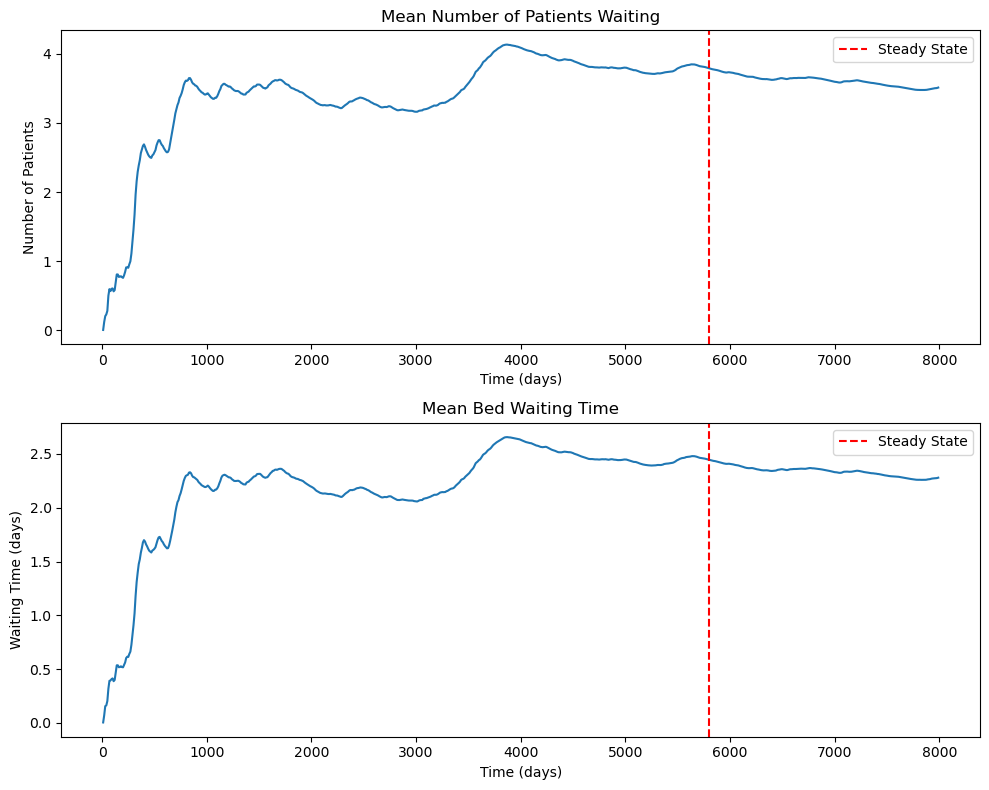

In [34]:
# Example usage:
warmup_results = warmup_analysis(scenario, num_replications, audit_interval)
# Steady state at 5 days (7200 minutes)
##### MODIFICATION - changed steady state time #####
time_series_inspection(warmup_results, steady_state_time=5800)

In this code:
- The time_series_inspection function takes the results dictionary from the warmup_analysis function and an optional steady_state_time parameter (in minutes) to indicate the point at which a steady state has been reached.
- The function extracts the waiting_patients_df and wait_times_df DataFrames from the results dictionary.
- The audit times are converted from minutes to days for plotting purposes.
- A figure with two subplots is created using plt.subplots.
- In the first subplot, the mean of the columns in the waiting_patients_df DataFrame is plotted against the time in days.
- In the second subplot, the mean of the columns in the wait_times_df DataFrame is plotted against the time in days.
- If the steady_state_time parameter is provided, a vertical line is drawn on both subplots at the corresponding time in days, indicating the steady state (warm-up period).
- Appropriate titles, labels, and legends are added to the subplots.
- The plt.tight_layout() function is called to ensure proper spacing between the subplots.
- The plt.show() function is called to display the plot.
- In the example usage, the time_series_inspection function is called with the warmup_results dictionary and a steady_state_time of 7200 minutes (5 days).

This implementation allows you to visualize the mean number of patients waiting and the mean bed waiting time over the course of the model run, with the option to add a vertical line indicating the point at which a steady state has been reached (warm-up period). This can help in identifying the warm-up period and determining when the model reaches a steady state for further analysis or data collection.

**Checks**

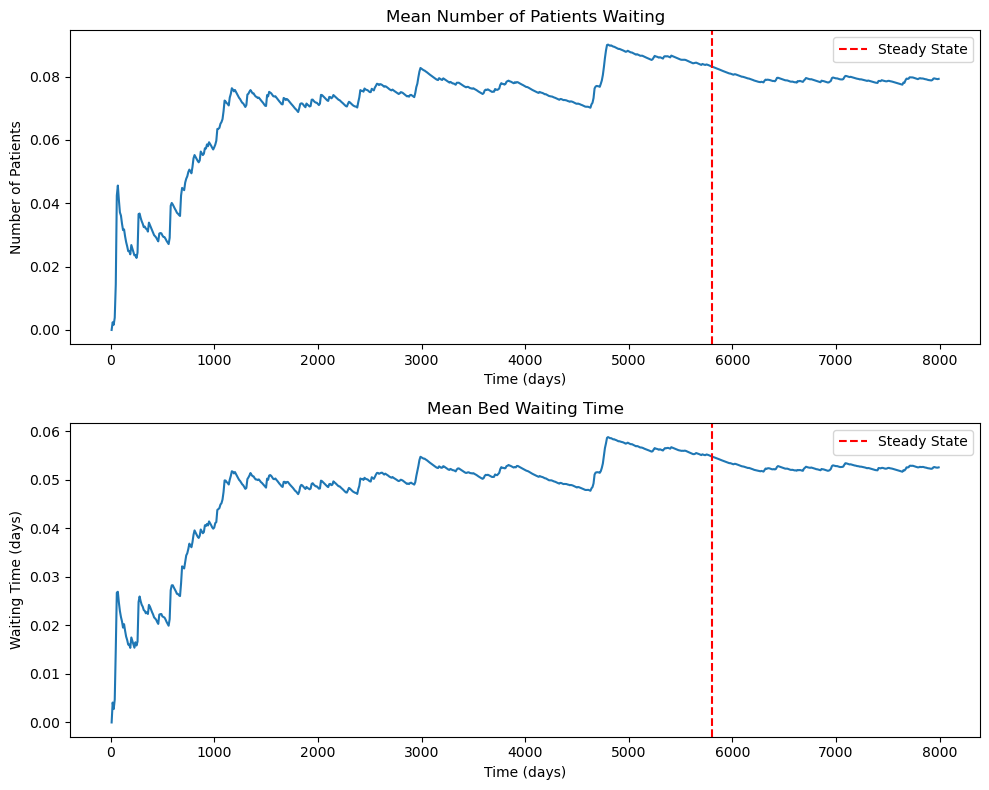

In [36]:
# Changing the number of beds
scenario = Scenario(num_beds=14, seed=42, run_length=8000)
num_replications = 10
audit_interval = 10

warmup_results = warmup_analysis(scenario, num_replications, audit_interval)
time_series_inspection(warmup_results, steady_state_time=5800)

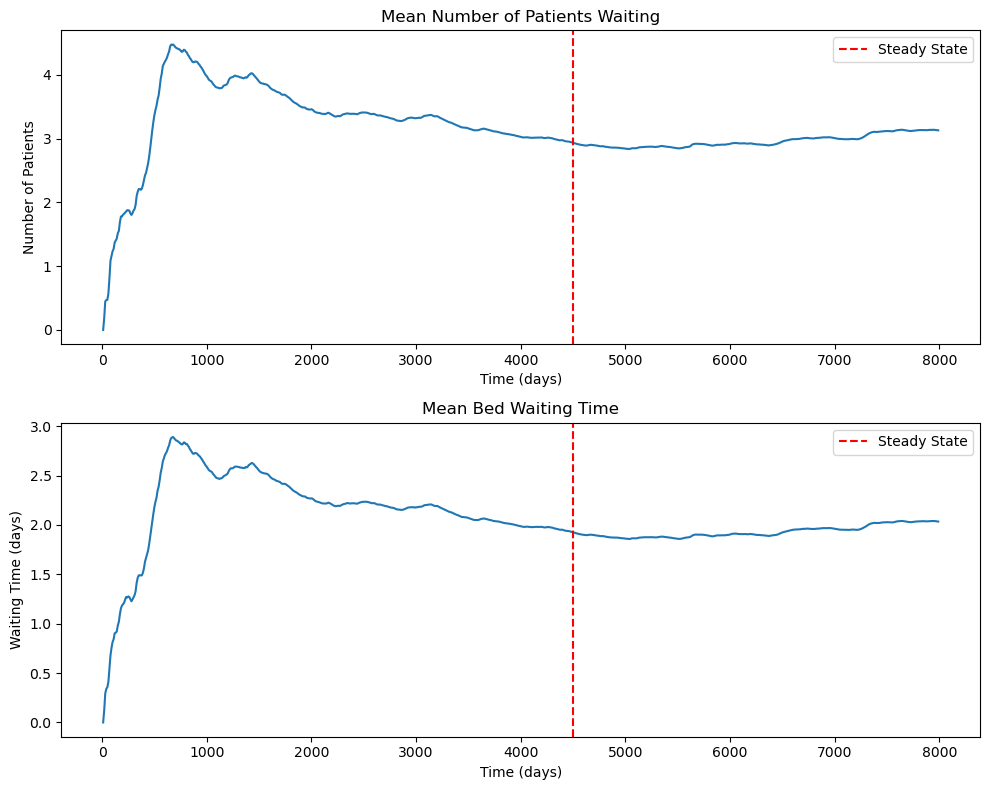

In [38]:
# Changing the random seed
scenario = Scenario(num_beds=10, seed=1, run_length=8000)
num_replications = 10
audit_interval = 10

warmup_results = warmup_analysis(scenario, num_replications, audit_interval)
time_series_inspection(warmup_results, steady_state_time=4500)

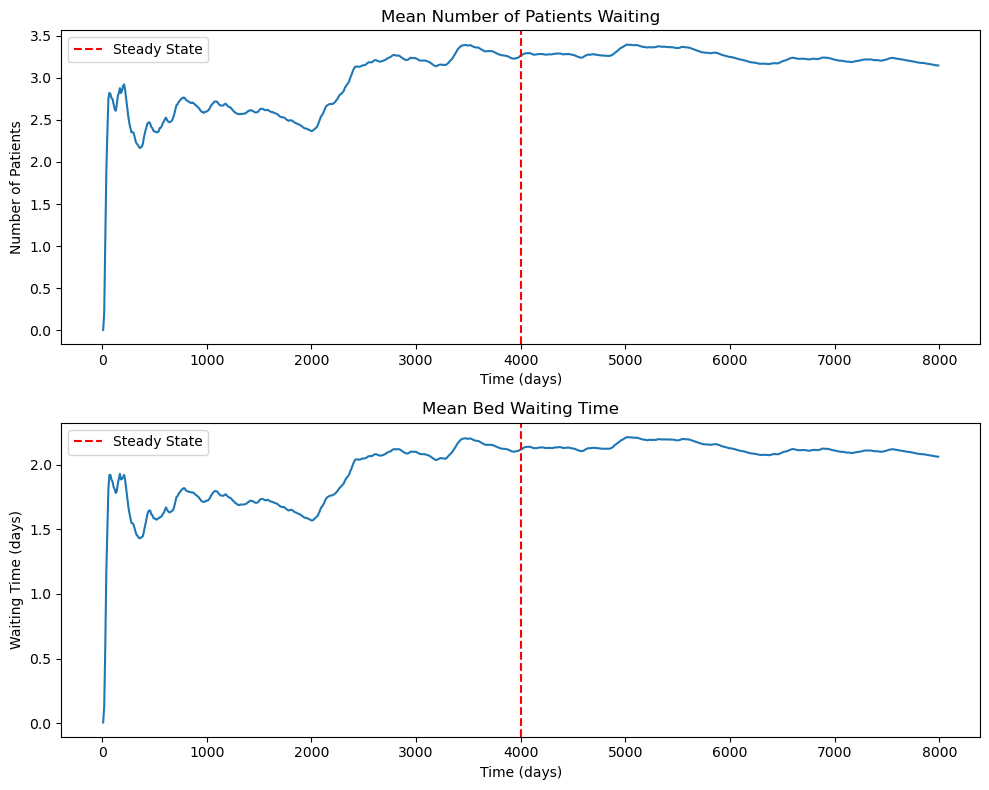

In [40]:
# Changing the random seed
scenario = Scenario(num_beds=10, seed=10, run_length=8000)
num_replications = 10
audit_interval = 10

warmup_results = warmup_analysis(scenario, num_replications, audit_interval)
time_series_inspection(warmup_results, steady_state_time=4000)

**Reflection**

The LLM forgot that the time being used throughout the model is in days, so attempted to implement this in minutes, which was then corrected in the model. The LLM was able to produce the plots of the waiting times and number of patients waiting, although the results are very different to those suggested in the paper by Monks et al. (2016), as there seems to be a significant amount of fluctuation in the results for nearly 6000 days for random seed of 42 and over 4000 for random seeds 1 and 10, as opposed to a suggested warm-up period of 1100 days in the paper.   